# LSTM을 이용한 스팸 메일 분류
---
RNN(순환신경망)의 대표 모형인 LSTM을 이용한 스팸 메일 분류

### 데이터 불러오기

In [1]:
import pandas as pd
import urllib.request

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")

('spam.csv', <http.client.HTTPMessage at 0x1ead6e982b0>)

In [3]:
data = pd.read_csv('spam.csv', encoding='latin1')

### 분석 데이터 추출

In [4]:
print('총 샘플의 수: ', len(data))
data.head()

총 샘플의 수:  5572


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

In [6]:
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print('결측값 여부: ', data.isnull().values.any())

결측값 여부:  False


In [8]:
# 중복여부 확인
print('v2 열의 유니크한 값: ', data['v2'].nunique())

v2 열의 유니크한 값:  5169


In [9]:
# v2 열에서 중복인 내용 제거
data.drop_duplicates(subset=['v2'], inplace=True)

<AxesSubplot:>

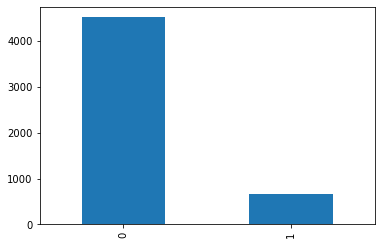

In [10]:
data['v1'].value_counts().plot(kind='bar')

In [11]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653


### 데이터 분할

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# stratify를 통해 레이블 분포가 고르게 분포하도록 함
X_data = data['v2']
y_data = data['v1']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                   test_size=0.2, 
                                                   random_state=1234, 
                                                   stratify=y_data)

In [14]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [15]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 87.331%
스팸 메일 = 12.669%


### 토큰화

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
tok = Tokenizer()
tok.fit_on_texts(X_train)
X_train_encoded = tok.texts_to_sequences(X_train)

In [18]:
print(X_train_encoded[:5])

[[1038, 948, 4, 533, 120, 2339, 3506, 24, 379, 249, 8, 1320, 949, 7, 1, 98, 92, 1, 211, 622, 14, 41, 175, 55, 534], [359, 95, 193, 387, 556, 308, 9, 3507, 2340, 2341, 56, 3508], [27, 152, 99, 1, 557, 187, 485, 20, 28, 40, 687, 127, 6, 26, 159, 111, 3509, 127, 794, 3510, 72, 49], [259, 333, 12, 558, 17, 18, 1, 56, 4, 334, 1321, 19, 950], [3511, 951, 107, 948, 17, 71, 1322, 156, 309, 4, 335, 325]]


### 패딩
---
패딩을 통해 텍스트 길이를 맞춰줌

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
MAXLEN = max(len(s) for s in X_train_encoded)
MAXLEN

189

In [21]:
X_train_padded = pad_sequences(X_train_encoded, maxlen=MAXLEN)
X_train_padded.shape

(4135, 189)

In [22]:
vocab_size = len(tok.word_index) + 1

### 모형 만들기

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원을 32로 설정
model.add(LSTM(32))                  # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          250272    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 258,625
Trainable params: 258,625
Non-trainable params: 0
_________________________________________________________________


### 학습하기

In [25]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 6s 72ms/step - loss: 0.3110 - acc: 0.8848 - val_loss: 0.1527 - val_acc: 0.9468
Epoch 2/4
52/52 [==============================] - 3s 53ms/step - loss: 0.1120 - acc: 0.9761 - val_loss: 0.0916 - val_acc: 0.9819
Epoch 3/4
52/52 [==============================] - 3s 57ms/step - loss: 0.0569 - acc: 0.9879 - val_loss: 0.0702 - val_acc: 0.9819
Epoch 4/4
52/52 [==============================] - 3s 56ms/step - loss: 0.0585 - acc: 0.9825 - val_loss: 0.0662 - val_acc: 0.9819


In [27]:
X_test_encoded = tok.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAXLEN)

In [28]:
print("\n 테스트 정확도: %.4f"%(model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 0s 12ms/step - loss: 0.0514 - acc: 0.9884

 테스트 정확도: 0.9884
